#### Download the given dataset

In [ ]:
# import necessary packages
import os, time
import torch 
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt
from torch.backends import cudnn 
from torch.utils.data import Dataset, DataLoader
from utils import download_given_data, get_preds_figure
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
import pandas as pd
from torchvision.models.resnet import BasicBlock
from torch.utils.tensorboard import SummaryWriter
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True
download_given_data('./')

Data downloaded and extracted!


In [ ]:
class OurDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship']

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

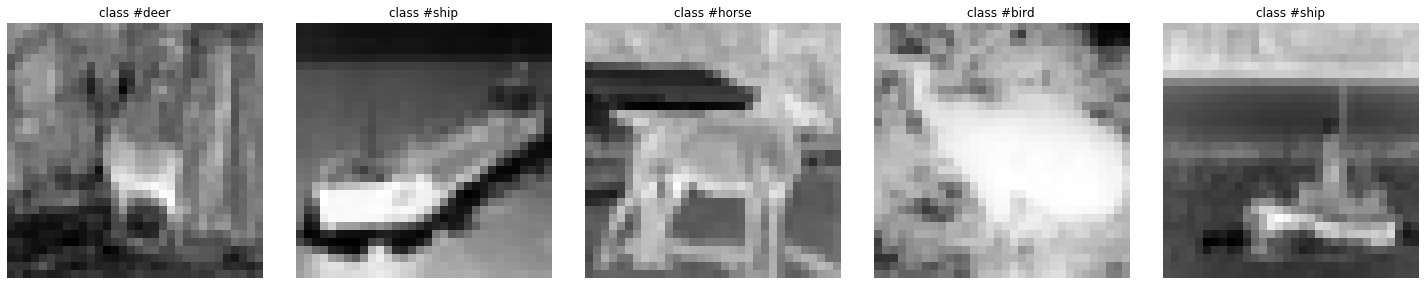

total number of training set: 36000
numer of images for class airplane: 4000
numer of images for class automobile: 4000
numer of images for class bird: 4000
numer of images for class cat: 4000
numer of images for class deer: 4000
numer of images for class dog: 4000
numer of images for class frog: 4000
numer of images for class horse: 4000
numer of images for class ship: 4000


In [ ]:
# Create a train_set from the train.csv file without any transformations
train_set = OurDataset(csv_file='./given_data/train.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(20, 15))

for i in range(len(idx)):
    image, label = train_set[idx[i]]['image'], train_set[idx[i]]['label']
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the training set
print('total number of training set: {}'.format(len(train_set)))

# Print the number of images per class in the training set
class_num_train = np.zeros(9, dtype=np.int32)
for x in train_set:
    class_num_train[x['label']] += 1
for i in range(9):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], class_num_train[i]))

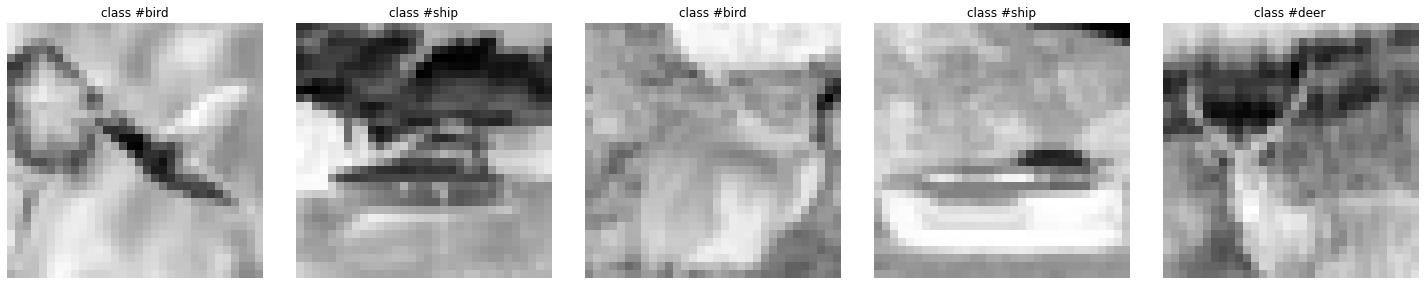

total number of valid set: 9000
numer of images for class airplane: 1000
numer of images for class automobile: 1000
numer of images for class bird: 1000
numer of images for class cat: 1000
numer of images for class deer: 1000
numer of images for class dog: 1000
numer of images for class frog: 1000
numer of images for class horse: 1000
numer of images for class ship: 1000


In [ ]:
# Create a valid_set from the val.csv file without any transformations
valid_set = OurDataset(csv_file='./given_data/val.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(20, 15))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]['image'], valid_set[idx[i]]['label']
    label_name = valid_set.label_names[label]

    # TODO: show plots

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)
plt.show()

# TODO: Print the number of total images in the validation set    
print('total number of valid set: {}'.format(len(valid_set)))
# TODO: Print the number of images per class in the validation set
class_num_val = np.zeros(9, dtype=np.int32)

for x in valid_set:
    class_num_val[x['label']] += 1
for i in range(9):
    print('numer of images for class {}: {}'.format(valid_set.label_names[i], class_num_val[i]))

In [ ]:
class RandomWindowDrop(object):
    def __init__(self, window_size):
        assert isinstance(window_size, (int, tuple))
        if isinstance(window_size, int):
            self.window_size = (window_size, window_size)
        else:
            assert len(window_size) == 2
            self.window_size = window_size
        
        # Define a horizontalFlip
        self.trans = transforms.RandomHorizontalFlip(p=1.0)

    def __call__(self, sample):
        image = sample

        # Perform either RandomWindowDrop or RandomHorizontalFlip
        if random.random() < 0.5:
            h, w = image.size
            imagePixels = image.load()
            top = np.random.randint(self.window_size[0], h - self.window_size[0])
            left = np.random.randint(self.window_size[1], w - self.window_size[1])
            for i in range(top, top+self.window_size[0], 1):
                for j in range(left, left+self.window_size[1], 1):   
                    imagePixels[i, j] = 0
        else:
            image = self.trans(image)

        return image

In [ ]:
class Noise():
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)

In [ ]:
def getTrainingData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    # transforms.Compose create a list of transformations
    transformed_training = OurDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            #GaussianNoise(),
                                            #NoiseDataset(),
                                            #UnetGenerator(),
                            
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomVerticalFlip(p=0.5),
                                            transforms.RandomRotation(20),
                                            #transforms.Pad(padding=1, fill=0, padding_mode=constant),
                                            #transforms.RandomAffine(degrees, translate=None, scale=None,shear=None, resample=False, fillcolor=0),
                                            #transforms.Compose([Noise(0.1, 0.05)]),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))

    dataloader_training = DataLoader(transformed_training, batch_size, shuffle=True, num_workers=0)

    return dataloader_training


def getEvalData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    # TODO: Part 1.4 (1 point)
    transformed_eval = OurDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=True, num_workers=0)

    return dataloader_eval


In [ ]:
train_loader = getTrainingData(csv_file='./given_data/train.csv', batch_size=64, num_workers=0)
valid_loader = getEvalData(csv_file='./given_data/val.csv', batch_size=64, num_workers=0)

In [ ]:
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 

        # define layers 
        #layer1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #layer2  
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Layer3

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        #layer4

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.relu7 = nn.ReLU()
        #self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.bn8 = nn.BatchNorm2d(512)
        #self.relu8 = nn.ReLU()
        #self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.bn9 = nn.BatchNorm2d(512)
        #self.relu9 = nn.ReLU()
        #self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.bn10 = nn.BatchNorm2d(512)
        #self.relu10 = nn.ReLU()
        
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Layer5

        #self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.bn11 = nn.BatchNorm2d(512)
        #self.relu11 = nn.ReLU()
        #self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.bn12 = nn.BatchNorm2d(512)
        #self.relu12 = nn.ReLU()
        #self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.bn13 = nn.BatchNorm2d(512)
        #self.relu13 = nn.ReLU()
        #self.conv14 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #self.bn14 = nn.BatchNorm2d(512)
        #self.relu14 = nn.ReLU()
        
        #self.max_pool5 = nn.MaxPool2d(kernel_size=2, stride=2)



        
        self.fc3 = nn.Linear(2048,100)
        self.drop1 = nn.Dropout(0.2)
        #self.fc4 = nn.Linear(4096,4096)
        #self.drop2 = nn.Dropout(0.7)
        #self.fc5 = nn.Linear(4096,1000)
        #self.drop3 = nn.Dropout(0.7)
        self.out = nn.Linear(100,9)
        self.drop4 = nn.Dropout(0.5)

    def forward(self, x):

        #layer1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)       
        x = self.max_pool1(x)
        #layer2
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)       
        x = self.max_pool2(x)

        #layer3
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)       
        x = self.max_pool3(x)

        #layer4
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        #x = self.conv8(x)
        #x = self.bn8(x)
        #x = self.relu8(x)

        #x = self.conv9(x)
        #x = self.bn9(x)
        #x = self.relu9(x)
        #x = self.conv10(x)
        #x = self.bn10(x)
        #x = self.relu10(x)       
        x = self.max_pool4(x)

        #layer5
        #x = self.conv11(x)
        #x = self.bn11(x)
        #x = self.relu11(x)
        #x = self.conv12(x)
        #x = self.bn12(x)
        #x = self.relu12(x)

        #x = self.conv13(x)
        #x = self.bn13(x)
        #x = self.relu13(x)
        #x = self.conv14(x)
        #x = self.bn14(x)
        #x = self.relu14(x)       
        #x = self.max_pool5(x)
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc3(x))
        x= self.drop1(x)
        #x = F.relu(self.fc4(x))
        #x= self.drop2(x)
        #x = F.relu(self.fc5(x))
        #x= self.drop3(x)
        x = self.out(x)
        #x = self.relu15(x)
        #x = self.fc4(x)
        #x = F.softmax(x)
        #x = self.fc5(x)
        #x = F.relu(x)
        
        return x

Network(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

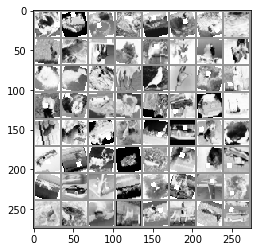

In [ ]:
# Create a train writer and a validation writer
# After training, to open tensorboard run
# tensorboard --logdir tb_graphs/ --port 5656
# The above command use to run a tensorboard for data in ./tb_graphs folder in port 5656
writer = SummaryWriter('tb_graphs/training')
val_writer = SummaryWriter('tb_graphs/validation')

net = Network(num_classes=9)

# Print out the layers of our model
print(net)

# Get some random training images
_iter = iter(train_loader)
samples = _iter.next()
images = samples['image']

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
plt.imshow(img_grid.mean(dim=0).cpu().numpy(), cmap="Greys")





In [ ]:
# evaluation function (not the same as in assignment 3)
def eval(net, loss_function, data_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    running_loss = 0.0
    for i, sample in enumerate(data_loader):
        # TODO: fill these blanks
        images, labels = sample['image'], sample['label']
        images = images.to(device)
        labels = labels.to(device)
        outs = net(images)
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        running_loss += loss_function(outs, labels).item()
        num_images += len(labels)

    acc = correct.float() / num_images
    loss = running_loss / len(data_loader)
    return acc, loss

# training function
def train(net, train_loader, valid_loader, writer, val_writer, loss_function):
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9, no weight decay
    optimizer = optim.SGD(net.parameters(),lr=0.01, momentum = 0.9)  #fill the blank bracket

    # Log training process to tensorboard every 100 iterations
    log_every = 100
    # Training for 20 epochs (you can modify this)
    epoches = 100
    for epoch in range(epoches):
        start_t = time.time()
        net.train() 
        running_loss = 0.0
        running_acc = 0.0
        for i, sample in enumerate(train_loader):
            # TODO: fill these blanks            
            images, labels = sample['image'], sample['label']
            images = images.to(device)
            labels = labels.to(device)
            outs = net(images)
            loss = loss_function(outs, labels) 
            _, preds = outs.max(1)
            correct = preds.eq(labels).sum()
            running_acc += correct.float() / len(labels)
            
            # TODO: clear grads, back-propagation, backward propogation, update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                        
            running_loss += loss.item()
            
            
            if i % log_every == 99: 
                
                print('[Epoch/iter]: [{}/{}], loss: {:.05f}, accuracy: {:.05f}'.format(epoch, i+1, 
                           running_loss / log_every, running_acc / log_every))

                log_index = epoch * len(train_loader) + i
                # Log the training loss and accuracy
                # Example of using .add_scalar()
                # Note tag='Loss'
                writer.add_scalar('Loss', running_loss / log_every, log_index) # tag='Loss'
                # TODO: load the training accuracy using writer (0.5 points)
                # Note tag='Accuracy'
                writer.add_scalar('Accuracy', running_acc / log_every, log_index )
                # Log predictions
                # Example of using .add_figure()
                writer.add_figure('predictions', get_preds_figure(net, images, labels), log_index)
                running_loss = 0.0
                running_acc = 0.0

        
        # Running the validation
        acc_eval, loss_eval = eval(net, loss_function, valid_loader)
        print('Elapsed time: {:.02f} seconds, end of epoch: {}, lr: {}, val_loss: {:.05f}, val_acc: {:.05f}'.format(
            time.time()-start_t, epoch, optimizer.param_groups[0]['lr'], loss_eval, acc_eval))
        # Log the validation loss and accuracy
        # TODO: load the validation loss using val_writer (0.5 points)
        # Using val_writer will log the values to the validation writer
        # Note tag='Loss'
        val_writer.add_scalar('Loss',loss_eval / log_every, log_index)
        
        # TODO: load the validation accuracy using val_writer (0.5 points)
        # Note tag='Accuracy'
        val_writer.add_scalar('Accuracy',acc_eval / log_every, log_index)

    return net

In [ ]:
print('Please wait patiently, it may take some seconds...')
# TODO: train your network here (0.5 points)
net.cuda()
print(f"model is on cuda : {next(net.parameters()).is_cuda}")
loss_function = torch.nn.CrossEntropyLoss().cuda()
trained_net = train(net,train_loader,valid_loader, writer, val_writer, loss_function)

# Save the weight of current model to disk
PATH = './final_net_with_100_epochs.pth'
torch.save(net.state_dict(), PATH)

# Load the model weights from './net.pth'
net.load_state_dict(torch.load('./final_net_with_100_epochs.pth'))

Please wait patiently, it may take some seconds...
model is on cuda : True
[Epoch/iter]: [0/100], loss: 1.99407, accuracy: 0.24516
[Epoch/iter]: [0/200], loss: 1.78306, accuracy: 0.34094
[Epoch/iter]: [0/300], loss: 1.73328, accuracy: 0.34469
[Epoch/iter]: [0/400], loss: 1.66939, accuracy: 0.38156
[Epoch/iter]: [0/500], loss: 1.59603, accuracy: 0.40937
Elapsed time: 29.37 seconds, end of epoch: 0, lr: 0.01, val_loss: 1.54060, val_acc: 0.40867
[Epoch/iter]: [1/100], loss: 1.56245, accuracy: 0.42953
[Epoch/iter]: [1/200], loss: 1.51966, accuracy: 0.44672
[Epoch/iter]: [1/300], loss: 1.48048, accuracy: 0.45828
[Epoch/iter]: [1/400], loss: 1.46794, accuracy: 0.46922
[Epoch/iter]: [1/500], loss: 1.44673, accuracy: 0.47422
Elapsed time: 27.80 seconds, end of epoch: 1, lr: 0.01, val_loss: 1.24030, val_acc: 0.52556
[Epoch/iter]: [2/100], loss: 1.36281, accuracy: 0.49922
[Epoch/iter]: [2/200], loss: 1.38622, accuracy: 0.50016
[Epoch/iter]: [2/300], loss: 1.32921, accuracy: 0.52359
[Epoch/iter]:

<All keys matched successfully>